In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import optuna # 🆕 Import Optuna

# ==============================================================================
# 1. SETUP (Paths and Transforms)
# ==============================================================================
data_dir = r"E:\New folder\isl_dataset-inverted"

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets once
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "valid"), transform=val_transforms)

num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    """This function trains a model with a set of hyperparameters and returns its validation accuracy."""
    
    # --- 2.1 Define the Hyperparameter Search Space ---
    
    # -- Optimizer and Learning Rate --
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    # -- Data Augmentation Strength --
    rotation_degrees = trial.suggest_int("rotation_degrees", 0, 25)
    color_jitter_brightness = trial.suggest_float("color_jitter_brightness", 0.1, 0.5)
    color_jitter_contrast = trial.suggest_float("color_jitter_contrast", 0.1, 0.5)
    
    # -- Model Hyperparameters --
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # --- 2.2 Define Transforms and DataLoaders FOR THIS TRIAL ---
    # Create the transforms using the parameters suggested for this trial
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=rotation_degrees),
        transforms.ColorJitter(brightness=color_jitter_brightness, contrast=color_jitter_contrast),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Validation transforms remain fixed
    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create new dataset objects with the trial-specific transforms
    train_dataset_trial = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
    
    # We can reuse the global validation dataset since its transform doesn't change
    train_loader = DataLoader(train_dataset_trial, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # --- 2.3 Model Setup ---
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_ftrs, num_classes)
    )
    model = model.to(device)

    # --- 2.4 Optimizer and Loss (with optimizer-specific params) ---
    if optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.85, 0.99)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else: # RMSprop
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
        
    criterion = nn.CrossEntropyLoss()
    
    # --- 2.5 Training Loop ---
    num_epochs = 15 # Keep epochs lower for faster tuning
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # --- 2.6 Validation ---
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_acc = val_corrects.double() / len(val_dataset)

    # --- 2.7 Return the metric you want to optimize ---
    return val_acc

# 3. RUN THE OPTIMIZATION STUDY
if __name__ == "__main__":
    # Create a study. 'direction="maximize"' means we want to find the highest validation accuracy.
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50) # You can change n_trials to 20, 50, 100 etc.
    
    print("\n\n--- OPTIMIZATION FINISHED ---")
    print("Number of finished trials: ", len(study.trials))
    
    print("\n--- BEST TRIAL ---")
    trial = study.best_trial
    print("Value (Best Validation Accuracy): ", trial.value)
    
    print("\n--- BEST HYPERPARAMETERS ---")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from pathlib import Path
from tqdm import tqdm
import os
import random
from typing import Tuple, List

config = {
    "data_path": Path(r"E:\New folder\isl_inverted"),  # Your dataset folder
    "num_epochs": 25,
    "batch_size": 16,
    "learning_rate": 0.000315,
    "dropout_rate": 0.4586,
    "rotation_degrees": 6,
    "color_jitter_brightness": 0.259,
    "color_jitter_contrast": 0.350,
    "optimizer": "Adam",
    "lr_scheduler_step_size": 7,
    "lr_scheduler_gamma": 0.1,
    "model_save_path": "optuna_b.pth",
    "train_split": 0.8
}

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def remove_empty_classes(folder: Path):
    """Remove class folders that have 0 images."""
    for class_name in os.listdir(folder):
        class_path = folder / class_name
        if not any(class_path.glob("*.jpg")) and not any(class_path.glob("*.jpeg")) and not any(class_path.glob("*.png")):
            print(f"Removing empty class folder: {class_path}")
            import shutil
            shutil.rmtree(class_path)

def create_dataloaders(data_path: Path, batch_size: int, config: dict) -> Tuple[DataLoader, DataLoader, List[str]]:
    print(f"Loading data from: {data_path}")

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=config["rotation_degrees"]),
        transforms.ColorJitter(brightness=config["color_jitter_brightness"], contrast=config["color_jitter_contrast"]),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])

    train_dir = data_path / "train"
    valid_dir = data_path / "valid"

    # If train/valid already exist → just load
    if train_dir.exists() and valid_dir.exists():
        remove_empty_classes(train_dir)
        remove_empty_classes(valid_dir)

        train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
        val_dataset = datasets.ImageFolder(valid_dir, transform=val_transforms)

    else:
        # Single folder dataset → split into train/valid
        full_dataset = datasets.ImageFolder(data_path, transform=train_transforms)
        total_size = len(full_dataset)
        train_size = int(config["train_split"] * total_size)
        val_size = total_size - train_size
        train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

        # Assign val transforms
        val_dataset.dataset.transform = val_transforms

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    class_names = train_dataset.dataset.classes if hasattr(train_dataset, "dataset") else train_dataset.classes
    print(f"Found {len(class_names)} classes.")
    return train_loader, val_loader, class_names

def build_model(num_classes: int, dropout_rate: float) -> nn.Module:
    print("Building EfficientNet-B0 model...")
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    num_input_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_input_features, num_classes)
    )
    return model

def train_model_loop(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                     class_names: List[str], config: dict, device: torch.device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["lr_scheduler_step_size"], gamma=config["lr_scheduler_gamma"])
    best_val_accuracy = 0.0
    
    print("\n--- Starting Model Training ---")
    for epoch in range(config["num_epochs"]):
        print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
        print('-' * 20)

        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        scheduler.step()
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Val Loss: {val_epoch_loss:.4f}   | Val Acc: {val_epoch_acc:.4f}")

        # Save best model
        if val_epoch_acc >= best_val_accuracy:
            best_val_accuracy = val_epoch_acc
            torch.save({'model_state_dict': model.state_dict(), 'class_names': class_names}, config["model_save_path"])
            print(f"🎉 New best model saved with accuracy: {best_val_accuracy:.4f}")

    print(f"\n--- Training Complete ---")
    print(f"Best validation accuracy achieved: {best_val_accuracy:.4f}")

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    train_loader, val_loader, class_names = create_dataloaders(config["data_path"], config["batch_size"], config)
    model = build_model(len(class_names), config["dropout_rate"]).to(device)
    train_model_loop(model, train_loader, val_loader, class_names, config, device)


Using device: cuda
Loading data from: E:\New folder\isl_inverted
Found 30 classes.
Building EfficientNet-B0 model...

--- Starting Model Training ---

Epoch 1/25
--------------------


Training: 100%|██████████| 149/149 [00:35<00:00,  4.22it/s]


Train Loss: 1.4712 | Train Acc: 0.7139


Validating: 100%|██████████| 43/43 [00:16<00:00,  2.59it/s]


Val Loss: 0.1579   | Val Acc: 0.9767
🎉 New best model saved with accuracy: 0.9767

Epoch 2/25
--------------------


Training: 100%|██████████| 149/149 [00:34<00:00,  4.27it/s]


Train Loss: 0.0973 | Train Acc: 0.9899


Validating: 100%|██████████| 43/43 [00:16<00:00,  2.67it/s]


Val Loss: 0.0658   | Val Acc: 0.9840
🎉 New best model saved with accuracy: 0.9840

Epoch 3/25
--------------------


Training: 100%|██████████| 149/149 [00:35<00:00,  4.23it/s]


Train Loss: 0.0457 | Train Acc: 0.9945


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.79it/s]


Val Loss: 0.0511   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 4/25
--------------------


Training: 100%|██████████| 149/149 [00:34<00:00,  4.37it/s]


Train Loss: 0.0275 | Train Acc: 0.9954


Validating: 100%|██████████| 43/43 [00:16<00:00,  2.68it/s]


Val Loss: 0.0956   | Val Acc: 0.9869
🎉 New best model saved with accuracy: 0.9869

Epoch 5/25
--------------------


Training: 100%|██████████| 149/149 [00:35<00:00,  4.21it/s]


Train Loss: 0.0260 | Train Acc: 0.9945


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.78it/s]


Val Loss: 0.0710   | Val Acc: 0.9811
🎉 New best model saved with accuracy: 0.9811

Epoch 6/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.51it/s]


Train Loss: 0.0131 | Train Acc: 0.9987


Validating: 100%|██████████| 43/43 [00:16<00:00,  2.58it/s]


Val Loss: 0.0547   | Val Acc: 0.9855
🎉 New best model saved with accuracy: 0.9855

Epoch 7/25
--------------------


Training: 100%|██████████| 149/149 [00:35<00:00,  4.20it/s]


Train Loss: 0.0313 | Train Acc: 0.9941


Validating: 100%|██████████| 43/43 [00:18<00:00,  2.39it/s]


Val Loss: 0.0868   | Val Acc: 0.9811
🎉 New best model saved with accuracy: 0.9811

Epoch 8/25
--------------------


Training: 100%|██████████| 149/149 [00:34<00:00,  4.26it/s]


Train Loss: 0.0139 | Train Acc: 0.9987


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.83it/s]


Val Loss: 0.0805   | Val Acc: 0.9869
🎉 New best model saved with accuracy: 0.9869

Epoch 9/25
--------------------


Training: 100%|██████████| 149/149 [00:34<00:00,  4.34it/s]


Train Loss: 0.0115 | Train Acc: 0.9975


Validating: 100%|██████████| 43/43 [00:16<00:00,  2.54it/s]


Val Loss: 0.0666   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 10/25
--------------------


Training: 100%|██████████| 149/149 [00:35<00:00,  4.21it/s]


Train Loss: 0.0096 | Train Acc: 0.9983


Validating: 100%|██████████| 43/43 [00:17<00:00,  2.50it/s]


Val Loss: 0.0673   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 11/25
--------------------


Training: 100%|██████████| 149/149 [00:34<00:00,  4.32it/s]


Train Loss: 0.0139 | Train Acc: 0.9971


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.82it/s]


Val Loss: 0.0616   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 12/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.51it/s]


Train Loss: 0.0054 | Train Acc: 0.9996


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.75it/s]


Val Loss: 0.0709   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 13/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.43it/s]


Train Loss: 0.0064 | Train Acc: 0.9996


Validating: 100%|██████████| 43/43 [00:14<00:00,  2.90it/s]


Val Loss: 0.0661   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 14/25
--------------------


Training: 100%|██████████| 149/149 [00:34<00:00,  4.35it/s]


Train Loss: 0.0067 | Train Acc: 0.9992


Validating: 100%|██████████| 43/43 [00:16<00:00,  2.65it/s]


Val Loss: 0.0660   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 15/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.40it/s]


Train Loss: 0.0055 | Train Acc: 0.9996


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.83it/s]


Val Loss: 0.0718   | Val Acc: 0.9869
🎉 New best model saved with accuracy: 0.9869

Epoch 16/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.50it/s]


Train Loss: 0.0035 | Train Acc: 1.0000


Validating: 100%|██████████| 43/43 [00:18<00:00,  2.29it/s]


Val Loss: 0.0655   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 17/25
--------------------


Training: 100%|██████████| 149/149 [00:36<00:00,  4.12it/s]


Train Loss: 0.0042 | Train Acc: 0.9992


Validating: 100%|██████████| 43/43 [00:17<00:00,  2.44it/s]


Val Loss: 0.0699   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 18/25
--------------------


Training: 100%|██████████| 149/149 [00:34<00:00,  4.37it/s]


Train Loss: 0.0049 | Train Acc: 0.9996


Validating: 100%|██████████| 43/43 [00:16<00:00,  2.69it/s]


Val Loss: 0.0651   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 19/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.42it/s]


Train Loss: 0.0060 | Train Acc: 0.9992


Validating: 100%|██████████| 43/43 [00:17<00:00,  2.49it/s]


Val Loss: 0.0687   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 20/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.43it/s]


Train Loss: 0.0039 | Train Acc: 1.0000


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.78it/s]


Val Loss: 0.0649   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 21/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.43it/s]


Train Loss: 0.0045 | Train Acc: 0.9996


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.72it/s]


Val Loss: 0.0642   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 22/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.47it/s]


Train Loss: 0.0040 | Train Acc: 1.0000


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.79it/s]


Val Loss: 0.0636   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 23/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.42it/s]


Train Loss: 0.0054 | Train Acc: 0.9996


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.79it/s]


Val Loss: 0.0693   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 24/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.42it/s]


Train Loss: 0.0046 | Train Acc: 0.9992


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.71it/s]


Val Loss: 0.0682   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

Epoch 25/25
--------------------


Training: 100%|██████████| 149/149 [00:33<00:00,  4.45it/s]


Train Loss: 0.0051 | Train Acc: 0.9992


Validating: 100%|██████████| 43/43 [00:15<00:00,  2.82it/s]

Val Loss: 0.0654   | Val Acc: 0.9884
🎉 New best model saved with accuracy: 0.9884

--- Training Complete ---
Best validation accuracy achieved: 0.9884


In [11]:
from pathlib import Path
from PIL import Image
import torch
from torchvision import transforms, models, datasets
from tqdm import tqdm
import torch.nn as nn
from collections import defaultdict

# ==== CONFIG ====
test_root = Path(r"E:\New folder\isl_inverted\test")
train_root = Path(r"E:\New folder\isl_inverted\train")   # 👈 Needed to recover mapping if not in checkpoint
model_path = "optuna_b.pth"

# ==== TRANSFORMS ====
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# ==== LOAD MODEL ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(model_path, map_location=device)

num_classes = checkpoint['model_state_dict']['classifier.1.weight'].shape[0]

model = models.efficientnet_b0(weights=None)
num_input_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4586),
    nn.Linear(num_input_features, num_classes)
)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# ==== LOAD CLASS MAPPING ====
if 'class_to_idx' in checkpoint:
    print("✅ Loaded class mapping from checkpoint")
    class_to_idx = checkpoint['class_to_idx']
else:
    print("⚠️ No mapping in checkpoint — loading from training folder")
    train_dataset = datasets.ImageFolder(train_root)
    class_to_idx = train_dataset.class_to_idx

idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print(f"Total classes (from mapping): {len(class_names)}")

# ==== ACCURACY COUNTERS ====
total_per_class = defaultdict(int)
correct_per_class = defaultdict(int)

# ==== LOOP OVER TEST IMAGES ====
with torch.no_grad():
    for img_path in tqdm(list(test_root.rglob("*.*")), desc="Testing"):
        if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
            continue
        
        true_class = img_path.parent.name
        image = Image.open(img_path).convert("RGB")
        input_tensor = test_transforms(image).unsqueeze(0).to(device)
        
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)
        pred_idx = pred.item()
        
        if pred_idx not in idx_to_class:
            print(f"⚠️ Skipping {img_path.name}: invalid pred_idx={pred_idx}")
            continue
        
        pred_class = idx_to_class[pred_idx]
        
        total_per_class[true_class] += 1
        if pred_class == true_class:
            correct_per_class[true_class] += 1

# ==== PRINT PER-CLASS RESULTS ====
print("\nPer-class accuracy:")
total_correct, total_images = 0, 0
for cls in class_names:
    total = total_per_class[cls]
    correct = correct_per_class[cls]
    total_images += total
    total_correct += correct
    if total > 0:
        acc = (correct / total) * 100
        print(f"{cls}: {correct}/{total} correct ({acc:.2f}%)")

# ==== OVERALL ACCURACY ====
if total_images > 0:
    overall_acc = (total_correct / total_images) * 100
    print(f"\n✅ Overall Accuracy: {overall_acc:.2f}% ({total_correct}/{total_images})")


C:\Users\vedan\AppData\Local\Temp\ipykernel_6072\4255323495.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


⚠️ No mapping in checkpoint — loading from training folder
Total classes (from mapping): 30


Testing: 100%|██████████| 324/324 [00:06<00:00, 51.28it/s]


Per-class accuracy:
Beautiful: 28/28 correct (100.00%)
Come: 8/8 correct (100.00%)
Drink: 4/4 correct (100.00%)
Eat: 8/8 correct (100.00%)
Fine_Okay: 8/8 correct (100.00%)
Friend: 8/8 correct (100.00%)
Go: 8/8 correct (100.00%)
Good: 8/8 correct (100.00%)
Happy: 4/4 correct (100.00%)
He_She_They: 12/12 correct (100.00%)
Hello_Hi: 8/8 correct (100.00%)
Help: 16/16 correct (100.00%)
How: 20/20 correct (100.00%)
Hungry: 12/12 correct (100.00%)
I_Me: 12/12 correct (100.00%)
Like: 12/12 correct (100.00%)
Love: 16/16 correct (100.00%)
My_Mine: 12/12 correct (100.00%)
No: 8/8 correct (100.00%)
See_Look: 12/16 correct (75.00%)
Sleep: 12/12 correct (100.00%)
Sorry: 8/8 correct (100.00%)
Want: 16/16 correct (100.00%)
We_Us: 4/4 correct (100.00%)
What: 8/8 correct (100.00%)
When: 8/8 correct (100.00%)
Where: 12/12 correct (100.00%)
Yes: 24/24 correct (100.00%)
You_Your: 4/4 correct (100.00%)

✅ Overall Accuracy: 98.77% (320/324)


Train root: E:\New folder\isl_inverted\train
Val root:   E:\New folder\isl_inverted\valid

📊 Train Class Distribution:
Beautiful      : 76
Come           : 60
Drink          : 100
Eat            : 92
Fine_Okay      : 80
Friend         : 76
Go             : 80
Good           : 72
Happy          : 96
He_She_They    : 72
Hello_Hi       : 68
Help           : 68
How            : 72
Hungry         : 76
I_Me           : 68
Like           : 92
Love           : 88
My_Mine        : 88
No             : 76
See_Look       : 80
Sleep          : 80
Sorry          : 88
Thank_You      : 80
Want           : 76
We_Us          : 104
What           : 68
When           : 96
Where          : 72
Yes            : 48
You_Your       : 88

📊 Validation Class Distribution:
Beautiful      : 16
Come           : 48
Drink          : 16
Eat            : 16
Fine_Okay      : 20
Friend         : 36
Go             : 28
Good           : 28
Happy          : 20
He_She_They    : 16
Hello_Hi       : 20
Help           : 24
How  

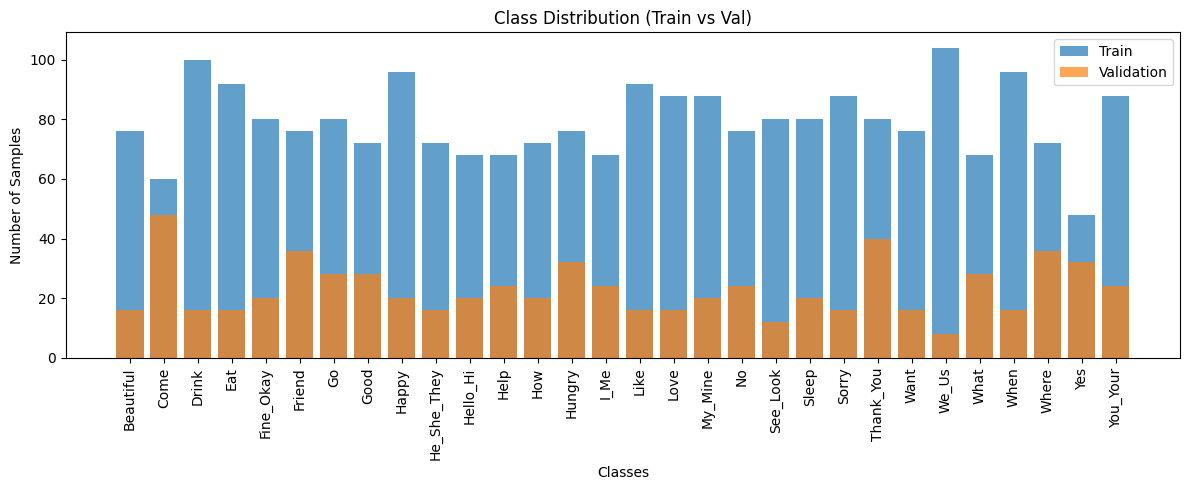


⚠️ Potentially underrepresented classes:
 - Come: 60 samples
 - Hello_Hi: 68 samples
 - Help: 68 samples
 - I_Me: 68 samples
 - What: 68 samples
 - Yes: 48 samples


In [13]:
from collections import Counter
import os
import matplotlib.pyplot as plt

# --- 1. Auto get paths from loaders ---
# works for ImageFolder datasets
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset

train_root = train_dataset.root
val_root = val_dataset.root

print(f"Train root: {train_root}")
print(f"Val root:   {val_root}")

# --- 2. Count images per class ---
def get_class_distribution(dataset):
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_counts = Counter([y for _, y in dataset.samples])
    return {idx_to_class[idx]: count for idx, count in class_counts.items()}

train_counts = get_class_distribution(train_dataset)
val_counts = get_class_distribution(val_dataset)

# --- 3. Print detailed class distributions ---
print("\n📊 Train Class Distribution:")
for cls, count in sorted(train_counts.items()):
    print(f"{cls:15}: {count}")

print("\n📊 Validation Class Distribution:")
for cls, count in sorted(val_counts.items()):
    print(f"{cls:15}: {count}")

# --- 4. Plot class distribution (visual imbalance check) ---
plt.figure(figsize=(12, 5))
plt.bar(train_counts.keys(), train_counts.values(), label='Train', alpha=0.7)
plt.bar(val_counts.keys(), val_counts.values(), label='Validation', alpha=0.7)
plt.xticks(rotation=90)
plt.title("Class Distribution (Train vs Val)")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.legend()
plt.tight_layout()
plt.show()

# --- 5. Optional: Highlight classes with few samples ---
threshold = min(train_counts.values()) * 1.5
low_classes = [cls for cls, count in train_counts.items() if count < threshold]
if low_classes:
    print("\n⚠️ Potentially underrepresented classes:")
    for cls in low_classes:
        print(f" - {cls}: {train_counts[cls]} samples")
else:
    print("\n✅ No significant class imbalance detected.")
